# MODIS

Visualizing the data from TERRA satellite.

In [2]:
# Import packages.
import warnings
import glob
import os
import calendar

from dask.diagnostics import ProgressBar

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np

# Figures inside this notebook.
%matplotlib inline

# Ignore matplotlib warning messages.
warnings.filterwarnings("ignore") 

In [3]:
# Directory containing data.
directory = "/media/alex/ALEXDATA/data_sets/MODIS/AOD/"

In [4]:
# All MODIS files paths.
files_paths = sorted(glob.glob(directory + "*nc"))

# Only TERRA satellite data files paths.
terra_files_paths = []
for file_path in files_paths:
    if "MOD08" in file_path:
        terra_files_paths.append(file_path)  

In [5]:
print(">>> Number of TERRA files:", len(terra_files_paths))

>>> Number of TERRA files: 6706


In [6]:
# Time span for AQUA satellite data.
print(os.path.split(terra_files_paths[0])[1])
print(os.path.split(terra_files_paths[-1])[1])

scrubbed.MOD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean.20000224.nc
scrubbed.MOD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean.20180828.nc


**BROKEN FILE!**

In [7]:
# Remove broken file.
terra_files_paths.remove("/media/alex/ALEXDATA/data_sets/MODIS/AOD/" + \
                         "scrubbed.MOD08_D3_6_1_AOD_550_Dark_Target_" + \
                         "Deep_Blue_Combined_Mean.20180622.nc")

In [8]:
%%time

# Read data.
AOD_ds = xr.open_mfdataset(terra_files_paths, engine="netcdf4", autoclose=True)
AOD_da = AOD_ds.MOD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean
AOD_da

CPU times: user 1min 46s, sys: 1.72 s, total: 1min 47s
Wall time: 2min 1s


<xarray.DataArray 'MOD08_D3_6_1_AOD_550_Dark_Target_Deep_Blue_Combined_Mean' (time: 6705, lat: 180, lon: 360)>
dask.array<shape=(6705, 180, 360), dtype=float64, chunksize=(1, 180, 360)>
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2000-02-24 2000-02-25 ... 2018-08-28
Attributes:
    Aggregation_Data_Set:             None
    Derived_From_Level_2_Data_Set:    AOD_550_Dark_Target_Deep_Blue_Combined
    Included_Level_2_Nighttime_Data:  False
    Level_2_Pixel_Values_Read_As:     Real
    Masked_With_QA_Usefulness_Flag:   True
    QA_Byte:                          5
    QA_Useful_Flag_Bit:               0
    QA_Value_Num_Bits:                2
    QA_Value_Start_Bit:               1
    Quality_Assurance_Data_Set:       Quality_Assurance_Land
    Statistic_Type:                   Simple
    long_name:                        Combi

**DANGER ZONE:** load data into memory!

In [9]:
with ProgressBar():
    AOD_da = AOD_da.compute()

[########################################] | 100% Completed |  1min 46.9s


In [10]:
# Monthly means.
AOD_da_mm = AOD_da.groupby("time.month").mean("time")

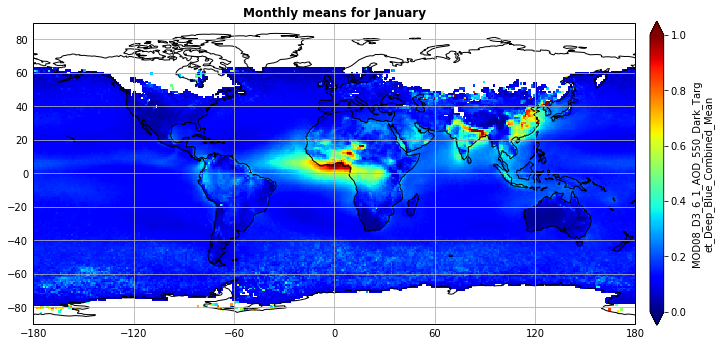

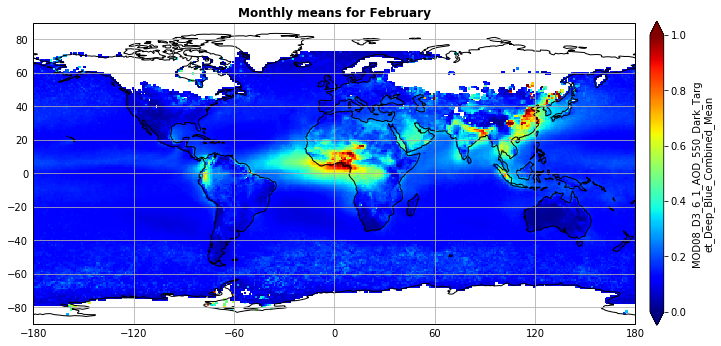

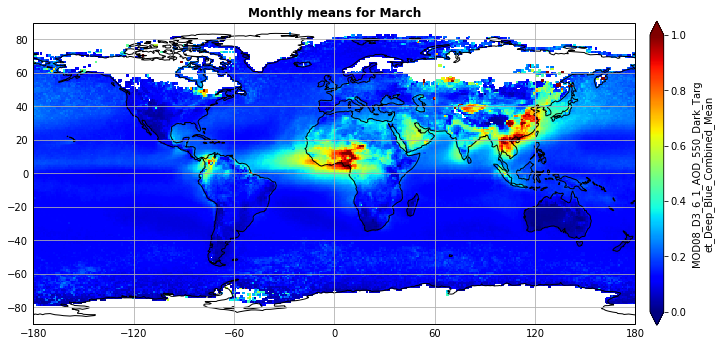

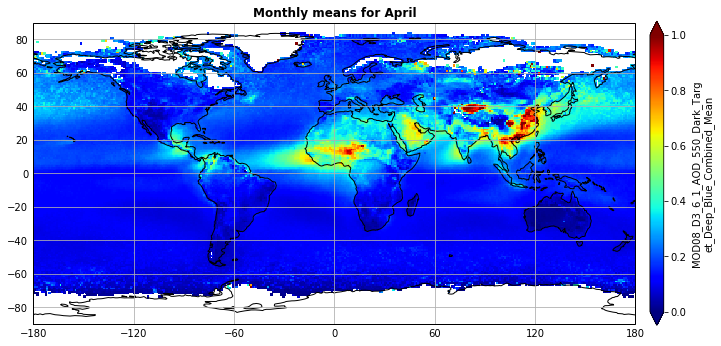

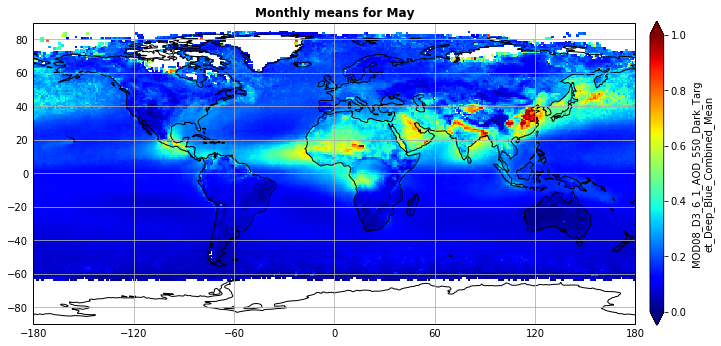

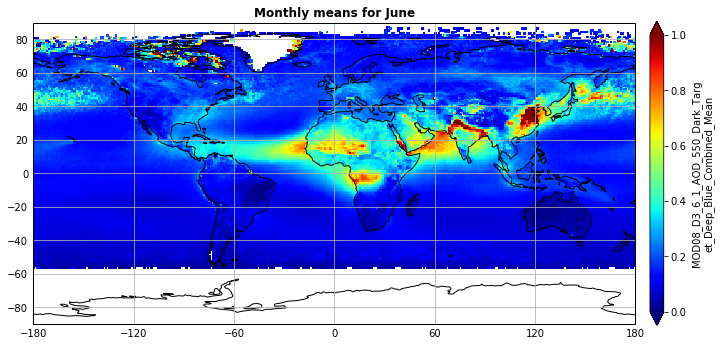

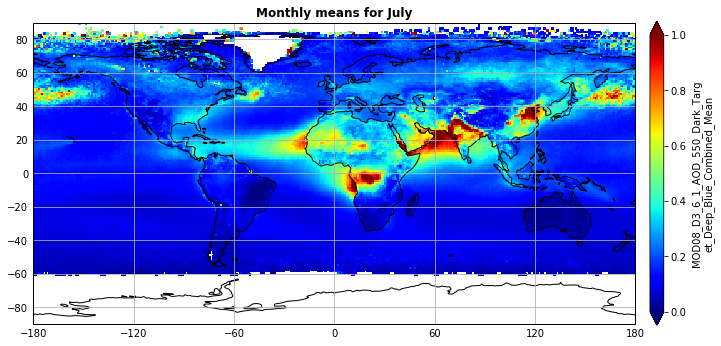

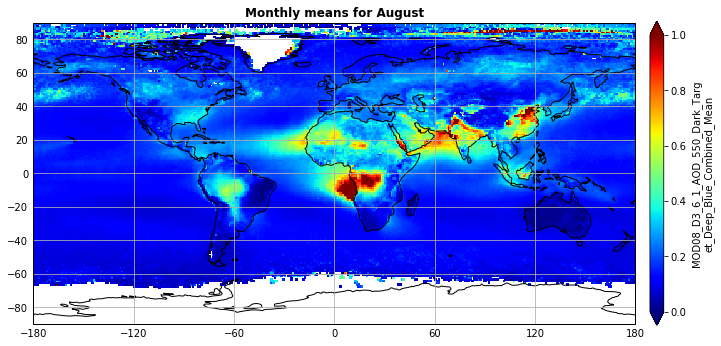

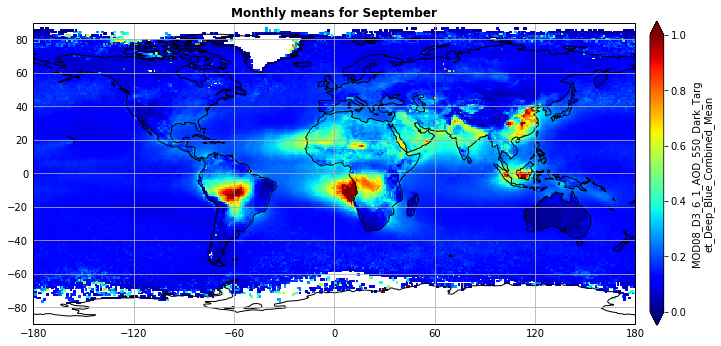

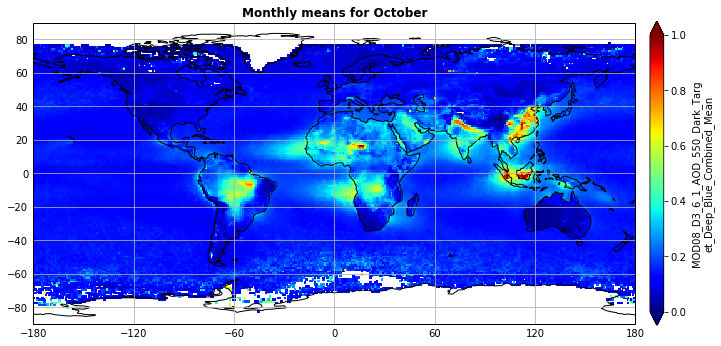

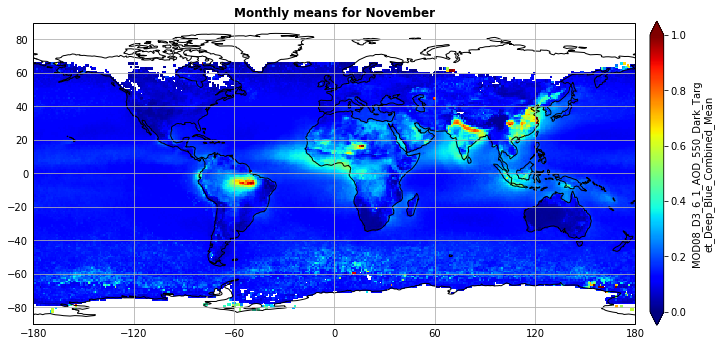

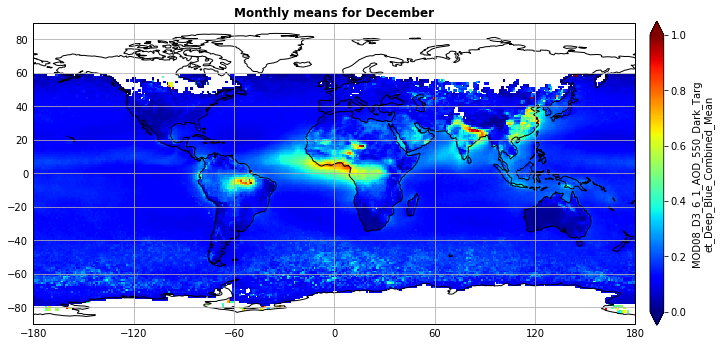

In [11]:
# Plot monthly means.
for month in range(1, 13):
    
    # Make map.
    fig = plt.figure(figsize=(13, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    map = AOD_da_mm.sel(month=month).plot(ax=ax, 
                                          vmin=0, vmax=1,
                                          cmap=plt.cm.jet, 
                                          cbar_kwargs={"shrink": 0.80,
                                                       "pad": 0.020,
                                                       "extend": "both"})
    ax.set_title("Monthly means for " + calendar.month_name[month], weight="bold");

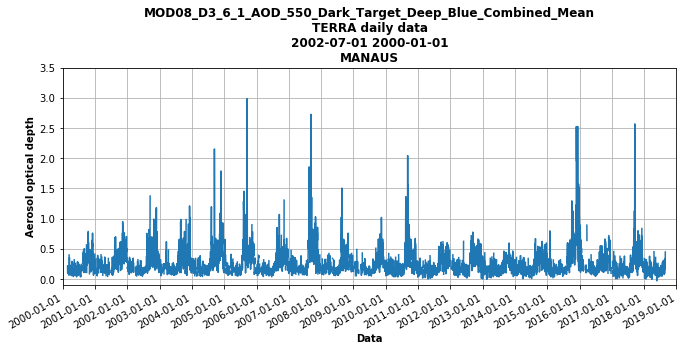

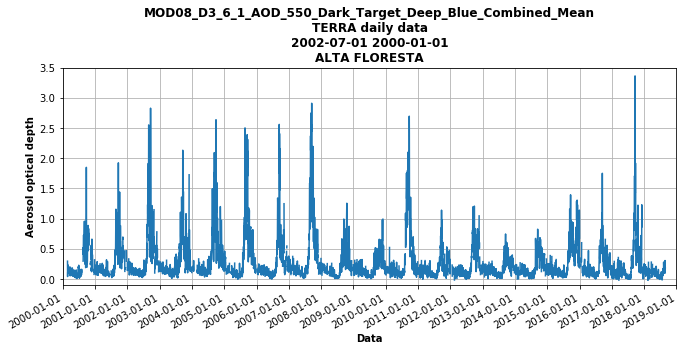

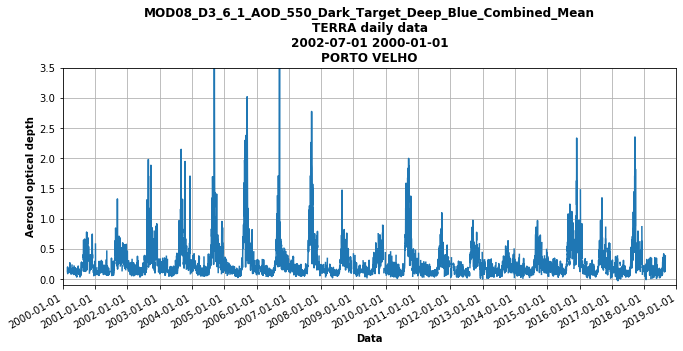

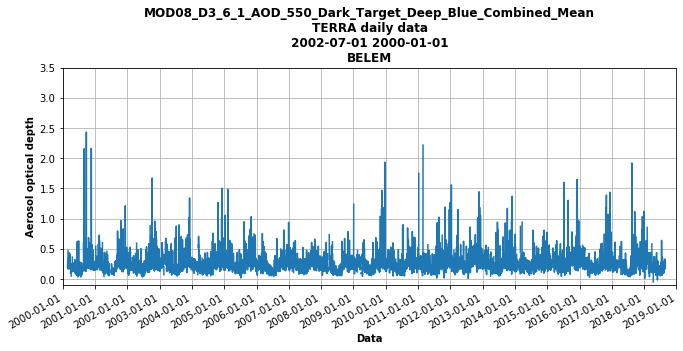

In [12]:
# Time series in some locations.
locations = [(-60, -3), (-56, -10), (-64, -7.5), (-48, -1)] 
labels = ["MANAUS", "ALTA FLORESTA", "PORTO VELHO", "BELEM"]
sat_name = "TERRA"
title = AOD_da.name
clabel = "Aerosol optical depth"

# Time span.
datei="2002-07-01"
datef="2000-01-01"

for location, label in zip(locations, labels):

    plt.figure(figsize=(11, 4))
    AOD_da.sel(lon=slice(location[0] - 3, location[0] + 3), 
               lat=slice(location[1] - 3, location[1] + 3)).\
               mean(dim=["lon", "lat"]).plot()
    plt.xticks(pd.date_range(start="2000", end="2019", freq="YS"))
    plt.xlim((pd.Timestamp("2000"), pd.Timestamp("2019")))
    plt.ylim((-0.1, 3.5))
    plt.title(title + "\nTERRA daily data\n" + datei + " " + datef + "\n" +
              label, fontweight="bold")
    plt.xlabel("Data", fontweight="bold")
    plt.ylabel(clabel, fontweight="bold")
    plt.grid();

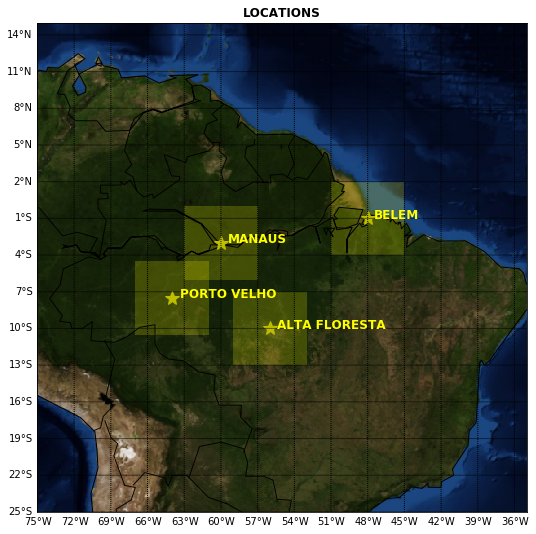

In [13]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

plt.figure(figsize=(9, 9))
plt.title("LOCATIONS", fontweight="bold")

# Corners of the map.
C1, C2, C3, C4 = -25, 15, -75, -35

# Create the map.
m = Basemap(projection="cyl", 
            llcrnrlat=C1, urcrnrlat=C2, 
            llcrnrlon=C3, urcrnrlon=C4, 
            resolution='c')

# Colors and frontiers for the map 
m.bluemarble()
m.drawcoastlines()
m.drawcountries(linewidth=0.9)

for loc, lab in zip(locations, labels):

    # Create a polygon delimiting the data region.
    poly = Polygon([m(loc[0] - 3, loc[1] - 3),
                    m(loc[0] - 3, loc[1] + 3),
                    m(loc[0] + 3, loc[1] + 3),
                    m(loc[0] + 3, loc[1] - 3)], facecolor="yellow", alpha=0.2)
    plt.gca().add_patch(poly)
    
    x, y = m(loc[0], loc[1])
    m.plot(x, y, '*y', markersize=15)
    plt.text(x * 0.99, y, lab, fontsize=12, fontweight="bold", color="yellow")
    
# Parallels and meridians on map. 
parallels = np.arange(np.int(C1), np.int(C2), np.int((C2 - C1) / 12))
meridians = np.arange(np.int(C3), np.int(C4), np.int((C4 - C3) / 12))
m.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10)
m.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10);